# DMQC Report: WMO [WMO Number]

## Current status and metadata: 

- What kind of float?
- Active/inactive? When?
- Where is it?
- How many cycles has it completed?
- Is there in-air data?
- What mode is the data in right now?
- What is the gain with the data as is?

In [7]:
import warnings
warnings.filterwarnings('ignore')

from matplotlib.dates import datestr2num
import matplotlib.pyplot as plt

from pathlib import Path
import numpy as np
import pandas as pd
import bgcArgoDMQC as bgc

wmo = 4900497 # insert WMO number here
fig_path = Path('../../../figures/') / f'{wmo}' # where to save figures
fig_path.mkdir(exist_ok=True)
bgc.io.get_argo(wmo, local_path=bgc.io.Path.ARGO_PATH) # download the data to ensure you have up to date files
flt = bgc.sprof(wmo)
flt.clean()
gains = flt.calc_gains(ref='WOA') # calculate gain, can change to ref='NCEP' if in-air data is available
print(np.nanmean(gains))

\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_BRtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_Rtraj.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_Sprof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_meta.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_prof.nc
\Users\GordonC\Documents\data\Argo\dac\meds\4900497\4900497_tech.nc
Extracting WOA data for Jan
Extracting WOA data for Feb
Extracting WOA data for Mar
Extracting WOA data for Apr
Extracting WOA data for May
Extracting WOA data for Jun
Extracting WOA data for Jul
Extracting WOA data for Aug
Extracting WOA data for Sep
Extracting WOA data for Oct
Extracting WOA data for Nov
Extracting WOA data for Dec
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple average of available data.
Bounding climatological profile(s) missing data - taking simple averag

## Visual QC

- Visualize the float and reference surface saturations, as well as the profiles. 
- Observe if DOXY data is set to '3' as it should be or if it is '1' or '2'. 
- Try to note cycles or other identifying features of potentially problematic profiles.

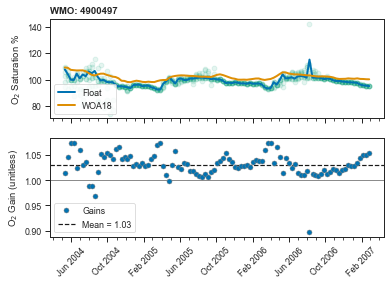

In [8]:
g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_initial.png', bbox_inches='tight', dpi=250)

Figure 1: Top panel: Float oxygen percent saturation (blue line) compared to WOA percent saturation (orange line), with DOXY audit flagged cycle percent saturation (green stars, if applicable) and raw float percent saturation (orange circles). Bottom panel: calculated gains (blue dots) and flagged gains from DOXY audit (orange stars).

Notes: One point/profile loosk out of range - investigate.

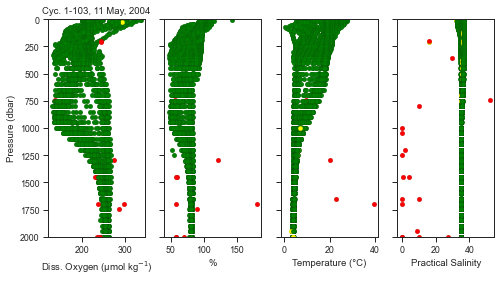

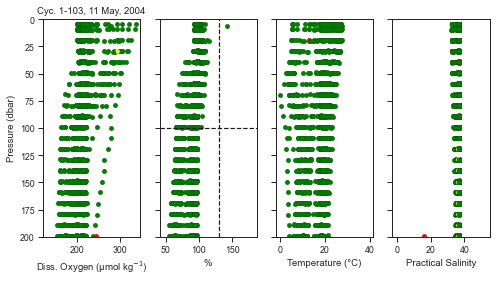

In [9]:
flt.reset()
g = flt.plot('qcprofiles', varlist=['DOXY', 'O2Sat', 'TEMP', 'PSAL'])
g.fig.savefig(fig_path / 'qcprofiles.png', bbox_inches='tight', dpi=250)
g = flt.plot('qcprofiles', varlist=['DOXY', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[1].axhline(100, color='k', linestyle='--')
g.axes[1].axvline(130, color='k', linestyle='--')
g.axes[0].set_ylim((200,0))
g.fig.savefig(fig_path / 'qcprofiles_shallow.png', bbox_inches='tight', dpi=250)

Figures 2,3: Profiles coloured by QC flag (1-2, green, 3, yellow, 4, red) on difference depth scales.

Notes: Single point, looks like it is caused by the physics since DOXY itself looks ok? Can probably just remove pt. w/ O2Sat > 125

## Flag bad data, recalculate gain

- Using the plots above (and likely some more specific plots, made on a case-by-case basis), flag bad DOXY data as 4. 
- After flagging bad data, re-clean the data and re-calculate the gains.


Calculating gains using WOA surface data and float O2 percent saturation...
1.032171348498115


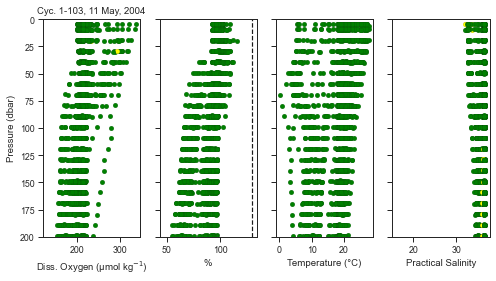

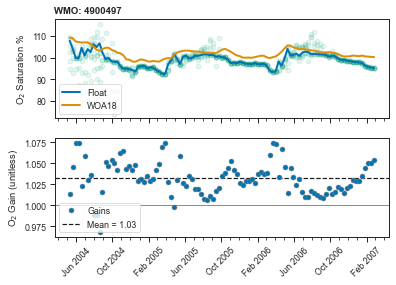

In [10]:
flt.reset()
bad_oxygen = (flt.O2Sat > 130) & (flt.PRES < 100) # index defining where the oxygen should be flagged as bad
flt.update_field('DOXY_QC', 4, where=bad_oxygen)
flt.update_field('DOXY_ADJUSTED_QC', 4, where=bad_oxygen)
flt.clean()
new_gains = flt.calc_gains(ref='WOA')
print(np.nanmean(new_gains))

g = flt.plot('qcprofiles', varlist=['DOXY', 'O2Sat', 'TEMP', 'PSAL'])
g.axes[1].axvline(130, color='k', linestyle='--')
g.axes[0].set_ylim((200,0))

g = flt.plot('gain', ref='WOA')
g.axes[0].set_title(f'WMO: {wmo}', loc='left', fontweight='bold')
g.axes[0].plot(flt.df.SDN.loc[flt.df.PRES < 50], flt.df.O2Sat.loc[flt.df.PRES < 50], 'o', zorder=0, alpha=0.1)
g.fig.savefig(fig_path / 'gain_final.png', bbox_inches='tight', dpi=250)

In [11]:

flt.__floatdict__['DOXY_QC'][bad_oxygen]

array([4])

Figure x: Repeated gain plot with bad data removed.

## Update Fields and Export

- DOXY should be 3 by default, but many old floats have 1 or 0. Though it will be redundant in some cases, make sure DOXY_QC is not good.
- Apply the gain to calculate DOXY_ADJUSTED. 
- Fill in DOXY_ADJUSTED_ERROR with an appropriate fixed value.
- Fill in DOXY_ADJUSTED_QC. 
- Make sure DOXY_ADJUSTED and DOXY_ADJUSTED_ERROR are `FillValue` wherever DOXY_ADJUSTED_QC is bad.
- Export the D-mode files. During export, HISTORY parameters will be filled as well as SCIENTIFIC_CALIB parameters using some default structures and user info set by calling `bgc.configure.configure()`.

In [12]:
# make sure DOXY_QC is 3 instead of 0,1,2
flt.update_field('DOXY_QC', 3, where=flt.DOXY_QC.isin([0, 1, 2]))
# fill in DOXY_ADJUSTED_QC appropriately
# flt.update_field('DOXY_ADJUSTED_QC', flt.DOXY_QC)
# flt.update_field('DOXY_ADJUSTED_QC', 1, where=flt.DOXY_ADJUSTED_QC.isin([0, 3]))
# flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.TEMP_ADJUSTED_QC == 4)
# flt.update_field('DOXY_ADJUSTED_QC', 3, where=flt.PSAL_ADJUSTED_QC == 4)
# make sure the data is FillValues where adjusted values are still bad
flt.update_field('DOXY_ADJUSTED_QC', 4, where=flt.DOXY_ADJUSTED.isna())
flt.set_fillvalue('DOXY_ADJUSTED', where=flt.DOXY_ADJUSTED_QC == 4)
flt.set_fillvalue('DOXY_ADJUSTED_ERROR', where=flt.DOXY_ADJUSTED_QC == 4)

In [13]:
# export the files
flt.export_files(data_mode='D')

Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_001.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_002.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_003.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_004.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_005.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_006.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_007.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_008.nc...done
Working on D-mode file /Users/GordonC/Documents/data/Argo/dac/meds/D/4900497/profiles/BD4900497_009.nc...done
Working on